# data 준비

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.utils as utils
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 64  # batch size 정의

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"using PyTorch version: {torch.version}, device: {device}")

train_dataset = datasets.MNIST(root='MNIST_data', # download 경로
                               train=True,        # training data 반환
                               # [0, 255] 범위 내의 PIL Image나 NumPy ndarray를 torch.FloatTensor로 변환
                               # image pixel 값[0, 255]을 [0.0, 1.0] 범위로 비례하여 조정(scale)
                               transform=transforms.ToTensor(),
                               # 해당 경로(root)에 MNIST data가 없다면 다운로드
                               download=True)
test_dataset = datasets.MNIST(root='MNIST_data',
                              train=False,        # test data 반환
                              transform=transforms.ToTensor(),
                              download=True)

print(f'type(train_dataset) = {type(train_dataset)}, len(train_dataset) = {len(train_dataset)}')
print(f'type(test_dataset) = {type(test_dataset)}, len(test_dataset) = {len(test_dataset)}')
print(f'train_dataset.data.shape = {train_dataset.data.shape}, train_dataset.data[0].type() = {train_dataset.data[0].type()}')
print(f'train_dataset.targets.shape = {train_dataset.targets.shape}, train_dataset.targets[0].type() = {train_dataset.targets[0].type()}')

tot_train_size = len(train_dataset)
train_size = int(tot_train_size * 0.85)       # 85% 를 train data로 분리
validation_size = tot_train_size - train_size # 나머지 15% 를 validation data로 분리

# train dataset의 분리
train_dataset, validation_dataset = utils.data.random_split(
                                    train_dataset,
                                    [train_size, validation_size])
# len(train_dataset): 6,0000 * 0.85 = 51,000
# len(validation_dataset): 6,0000 * 0.15 = 9,000
# len(test_dataset): 10,000
print(f'tot_train_size = {tot_train_size}, len(train_dataset) = {len(train_dataset)}, len(validation_dataset) = {len(validation_dataset)}')
print(f'len(test_dataset) = {len(test_dataset)}')

# batch data를 만들기 위해 DataLoader 설정
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)
validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)
test_dataset_loader = DataLoader(dataset=test_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)
# len(train_dataset): 6,0000 * 0.85 = 51,000
#    len(train_dataset_loader): 51,000 / 64 = 797
#
# len(validation_dataset): 6,0000 * 0.15 = 9,000
#    len(validation_dataset_loader): 9,000 / 64 = 141
#
# len(test_dataset) = 10,000
#    len(test_dataset_loader): 10,000 / 64 = 157
print(f'len(train_dataset_loader): {len(train_dataset_loader)}')
print(f'len(validation_dataset_loader): {len(validation_dataset_loader)}')
print(f'len(test_dataset_loader): {len(test_dataset_loader)}')

device = cuda
type(train_dataset) = <class 'torchvision.datasets.mnist.MNIST'>, len(train_dataset) = 60000
type(test_dataset) = <class 'torchvision.datasets.mnist.MNIST'>, len(test_dataset) = 10000
train_dataset.data.shape = torch.Size([60000, 28, 28]), train_dataset.data[0].type() = torch.ByteTensor
train_dataset.targets.shape = torch.Size([60000]), train_dataset.targets[0].type() = torch.LongTensor
tot_train_size = 60000, len(train_dataset) = 51000, len(validation_dataset) = 9000
len(test_dataset) = 10000
len(train_dataset_loader): 797
len(validation_dataset_loader): 141
len(test_dataset_loader): 157


# model 정의

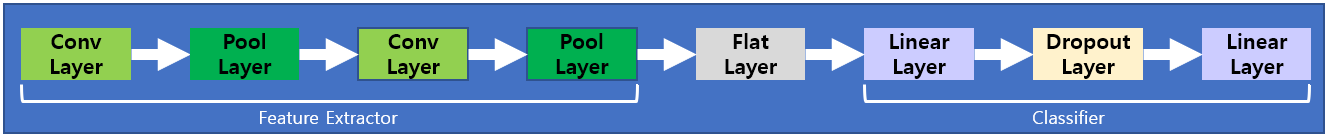

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__();

    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=32, # kernel의 수도 32
                           kernel_size=3,
                           padding=1)       # data의 크기에 변화가 없다
    self.conv2 = nn.Conv2d(in_channels=32,
                           out_channels=64, # kernel의 수도 64
                           kernel_size=3,
                           padding=1)
    # channel의 수는 불변이나 data 크기는 절반으로
    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=64*7*7, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=10)

    self.dropout25=nn.Dropout(p=0.25)
    self.dropout50=nn.Dropout(p=0.5)

  def forward(self, data):       # (?,  1, 28, 28)
    data = self.conv1(data)      # (?, 32, 28, 28), padding을 했기 때문에, size는 불변, channel 수만 변화
    data = torch.relu(data)      # (?, 32, 28, 28)
    data = self.pooling(data)    # (?, 32, 14, 14), channel은 그대로, size만 절반으로
    data = self.dropout25(data)  # (?, 32, 14, 14)

    data = self.conv2(data)      # (?, 64, 14, 14), padding을 했기 때문에, size는 불변, channel 수만 변화
    data = torch.relu(data)      # (?, 64, 14, 14)
    data = self.pooling(data)    # (?, 64,  7,  7), channel은 그대로, size만 절반으로
    data = self.dropout25(data)  # (?, 64,  7,  7)

    data = data.view(-1, 64*7*7) # (?, 3136)  = 64*7*7

    data = self.fc1(data)        # (?, 256)
    data = torch.relu(data)      # (?, 256)
    data = self.dropout50(data)  # (?, 256)

    data = self.fc2(data)        # (?, 10)

    return data

model = CNN().to(device)
print(model)

# CrossEntropyLoss() 에는 Softmax가 포함되어 있다.
# model의 출력값에 Softmax 함수를 적용한 후에 손실함수를 계산한다.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# parameter 확인
for name, child in model.named_children():
  for param in child.parameters():
    print(f'{name}: {param.size()}')

# test code
#inputs = torch.Tensor(1, 1, 28, 28)
#model(inputs)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
)


# model 학습 함수 정의

In [ ]:
def model_train(dataloader, model, criterion, optimizer):

  # model을 학습 mode로 ...
  # model parameters((Weight, Bias)를 update하는 mode
  model.train()

  train_loss_sum = train_correct = train_total =0
  total_train_batch = len(dataloader)

  '''
  ### Debug ####################################
  index = 0
  ### Debug ####################################
  '''

  # images: 입력 image, labels: 0~9 정답 숫자
  for images, labels in dataloader:
    # images.shape = (batch_size, 1, 28, 28)
    x_train = images.to(device)
    y_train = labels.to(device)

    outputs = model(x_train) # model에 대한 예측값 계산
    loss = criterion(outputs, y_train) # 손실함수 계산

    # 역전파(backpropagation)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    '''
    ### Debug ####################################
    if index > 0:
      break
    index += 1

    # 64: batch size
    print(f'images.shape = {images.shape}')    # images.shape = torch.Size([64, 1, 28, 28])
    print(f'labels.shape = {labels.shape}')    # labels.shape = torch.Size([64])
    print(f'x_train.shape = {x_train.shape}')  # x_train.shape = torch.Size([64, 1, 28, 28])
    print(f'y_train.shape = {y_train.shape}')  # y_train.shape = torch.Size([64])
    print(f'outputs.shape = {outputs.shape}')  # outputs.shape = torch.Size([64, 10])
    print(f'y_train = {y_train}')              # y_train = tensor([7, 7, 1, 3, 5, 6, 5, 2, 7, 5, 0, 0, 9, 1, 6, 6, 3, 3, 6, 0, 0, 0, 3, 5, 3, 6, 5, 7, 7, 6, 0, 2, 3, 1, 7, 0, 6, 9, 2, 7, 6, 1, 9, 3, 6, 5, 0, 8, 7, 5, 1, 3, 2, 8, 0, 1, 9, 3, 6, 9, 0, 7, 1, 0])
    print(f'outputs[0] = {outputs[0]}')        # outputs[0] = tensor([ 0.0545, -0.0425, -0.0098, -0.0102,  0.0009,  0.0576,  0.0604, -0.0201, -0.0058, -0.0459], grad_fn=<SelectBackward0>)
    print(f'torch.argmax(outputs, 1) = {torch.argmax(outputs, 1)}') # 0.0604 의 index 6 return
                                               # torch.argmax(outputs, 1) = tensor([6, 2, 2, 5, 2, 9, 2, 5, 0, 6, 5, 2, 6, 0, 5, 0, 2, 5, 2, 5, 9, 0, 2, 2, 2, 6, 9, 5, 5, 6, 2, 5, 5, 2, 0, 5, 5, 0, 2, 5, 5, 9, 0, 6, 1, 2, 5, 2, 2, 5, 2, 5, 5, 3, 6, 6, 6, 5, 2, 5, 5, 5, 3, 9])
    print(f'outputs = {outputs}')
    ### Debug ####################################
    '''

    train_total += y_train.size(0) # 64, size(): shape과 동일
    # argmax(tensor, dim=1): dim(열)을 기준(각 행에서)으로 안에 있는 최대값의 위치를 각각 반환
    # item(): tensor에 저장된 값만을 반환
    train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()

  # 학습 data의 평균 오차 계산
  train_avg_loss = train_loss_sum / total_train_batch
  # 학습 data의 평균 정확도 계산
  train_avg_accuracy = 100 * train_correct / train_total

  return (train_avg_loss, train_avg_accuracy)

### Debug ####################################
#model_train(train_dataset_loader, model, criterion, optimizer)
### Debug ####################################

# model 검증 함수 정의

In [ ]:
def model_evaluate(dataloader, model, loss_function, optimizer):

  # model을 평가(추론) mode로 ..
  # model의 parameter를 update 하지 않는 mode
  model.eval()

  # gradient를 계산하는 autograd engine을 비활성화한다.
  # 역전파(Backpropagation)에 필요한 메모리 등을 절약할 수 있어 계산 시 연산 속도가 빨라진다
  with torch.no_grad():
    # 검증 함수에는 역전파(Backpropagation) code가 없다.
    # 이 함수의 목적은 parameter를 학습을 하는 것이 아니라
    # 현재 model의 오차와 정확도를 알아내는 것이다.

    eval_loss_sum = eval_correct = eval_total = 0

    total_eval_batch = len(dataloader)

    for images, labels in dataloader:
      # images.shape = (batch_size, 1, 28, 28)
      x_eval = images.to(device)
      y_eval = labels.to(device)

      outputs = model(x_eval)
      loss = criterion(outputs, y_eval)

      # 역전파(backpropagation) code가 없다.

      eval_loss_sum += loss.item()

      eval_total += y_eval.size(0)
      eval_correct += (torch.argmax(outputs, 1) == y_eval).sum().item()

    # 검증 data의 평균 오차 계산
    eval_avg_loss = eval_loss_sum / total_eval_batch
    # 검증 data의 평균 정확도 계산
    eval_avg_accuracy = 100 * eval_correct / eval_total

    return (eval_avg_loss, eval_avg_accuracy)

# 학습

In [ ]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

eval_loss_list = []
eval_accuracy_list = []

start_time = datetime.now()

epochs = 20
for epoch in range(epochs):
  # model train
  train_avg_loss, train_avg_accuracy = model_train(
                  train_dataset_loader,
                  model,
                  criterion,
                  optimizer)
  train_loss_list.append(train_avg_loss)
  train_accuracy_list.append(train_avg_accuracy)

  # model evaluation
  eval_avg_loss, eval_avg_accuracy = model_evaluate(
                  validation_dataset_loader,
                  model,
                  criterion,
                  optimizer)
  eval_loss_list.append(eval_avg_loss)
  eval_accuracy_list.append(eval_avg_accuracy)

  print(f'epoch={epoch+1}, train_loss={train_avg_loss}, train_accuracy={train_avg_accuracy}, eval_loss={eval_avg_loss}, eval_accuracy={eval_avg_accuracy}')

end_time = datetime.now()
print('elapsed time => ', end_time-start_time)

epoch=0, train_loss=0.29604355321549713, train_accuracy=90.63921568627451, eval_loss=0.07346038026272828, eval_accuracy=97.67777777777778
epoch=1, train_loss=0.10653965821410231, train_accuracy=96.82352941176471, eval_loss=0.05360194838916262, eval_accuracy=98.31111111111112
epoch=2, train_loss=0.08121888150216794, train_accuracy=97.45686274509804, eval_loss=0.04820649105814411, eval_accuracy=98.52222222222223
epoch=3, train_loss=0.06954341452309355, train_accuracy=97.88823529411765, eval_loss=0.03912041812847411, eval_accuracy=98.92222222222222
epoch=4, train_loss=0.06107500671389205, train_accuracy=98.11764705882354, eval_loss=0.03741519374761347, eval_accuracy=98.94444444444444
epoch=5, train_loss=0.05297641115440722, train_accuracy=98.33725490196079, eval_loss=0.03558186100752932, eval_accuracy=98.94444444444444
epoch=6, train_loss=0.04803071163552071, train_accuracy=98.49803921568628, eval_loss=0.03519026405493405, eval_accuracy=98.96666666666667
epoch=7, train_loss=0.043824911324

# 시각화

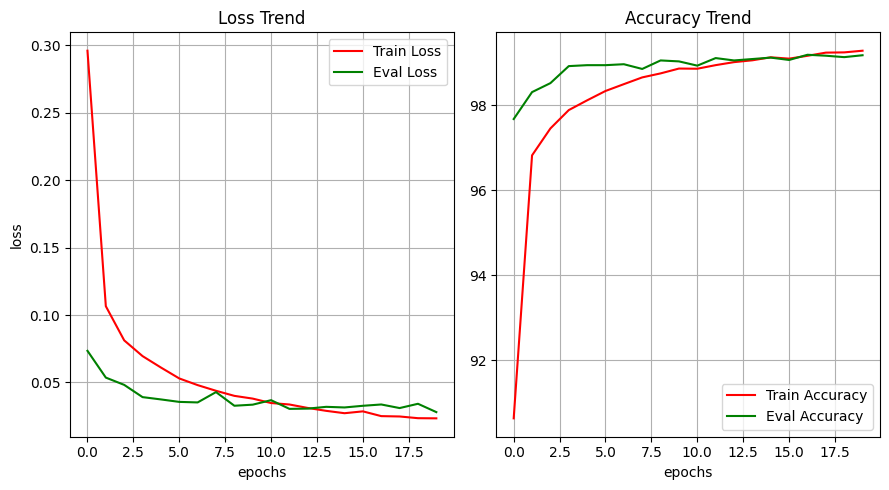

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

####################################################
plt.subplot(1, 2, 1)                # nrows=1, ncols=2, index=1
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, color='red', label='Train Loss')
plt.plot(eval_loss_list, color='green', label='Eval Loss')
plt.legend(loc='best')

####################################################
plt.subplot(1, 2, 2)                # nrows=1, ncols=2, index=2
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.grid()
plt.plot(train_accuracy_list, color='red', label='Train Accuracy')
plt.plot(eval_accuracy_list, color='green', label='Eval Accuracy')
plt.legend(loc='best')


plt.tight_layout()
plt.show()

# 평가

In [ ]:
# model_evaluate() 와 동일한 code
def model_test(dataloader, model, loss_function, optimizer):

  # model을 평가(추론) mode로 ..
  # model의 parameter를 update 하지 않는 mode
  model.eval()

  # gradient를 계산하는 autograd engine을 비활성화한다.
  # 역전파(Backpropagation)에 필요한 메모리 등을 절약할 수 있어 계산 시 연산 속도가 빨라진다
  with torch.no_grad():
    # 검증 함수에는 역전파(Backpropagation) code가 없다.
    # 이 함수의 목적은 parameter를 학습을 하는 것이 아니라
    # 현재 model의 오차와 정확도를 알아내는 것이다.

    test_loss_sum = test_correct = test_total = 0

    total_test_batch = len(dataloader)

    for images, labels in dataloader:
      # images.shape = (batch_size, 1, 28, 28)
      x_test = images.to(device)
      y_test = labels.to(device)

      outputs = model(x_test)
      loss = criterion(outputs, y_test)

      test_loss_sum += loss.item()

      test_total += y_test.size(0)
      test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()

    test_avg_loss = test_loss_sum / total_test_batch
    test_avg_accuracy = 100 * test_correct / test_total

    return (test_avg_loss, test_avg_accuracy)

test_loss, test_accuracy = model_test(
                  test_dataset_loader,
                  model,
                  criterion,
                  optimizer)
print(f'test_loss={test_loss}, test_accuracy={test_accuracy}')
# test_loss=0.021052071004398303, test_accuracy=99.33

test_loss=0.021052071004398303, test_accuracy=99.33
